# Sentinel-2 SITS dataset from open-source data

## How to get the "raw" Sentinel-2 satellite images

The raw Sentinel-2 imagery used in this notebook _can_ be generated by following the instructions in this blog post which introduces the Sentinel-Hub's machine learning package "eo-learn": https://medium.com/sentinel-hub/land-cover-classification-with-eo-learn-part-1-2471e8098195. 

**Alternatively, the satellite imagery including labels can be downloaded** here: 

http://eo-learn.sentinel-hub.com (eo-learn EOPatches, kindly provided by Sentinel Hub)

For this notebook, I assume you downloaded the sample dataset (eopatches_slovenia_2017_sample.zip, ~3 GB) and extracted it to a directory called "eodata". **Please adjust variable `root_dir` accordingly:**

In [1]:
root_dir = '../eodata'

## Pre-processing: Interpolation of missing values and smoothing of time series

* the raw Sentinel-2 data is provided as reflectance values of 6 channels of different bandwiths (i.e. 6 possible independent variables)


* as many time series methods (like the original implemenation of ROCKET) handles only **univariate** time series, the vegetation index NDVI is used as the independent variable here. NDVI is the normalized difference of channel 4 and 3 of the raw data


* labels: each pixel is labelled with a land cover class. There is a total of 10 classes in the full dataset; the **spatial subset used here and in the eo-learn blog post, however, contains only 6 land cover classes** of relevant numbers of pixels.


* after loading the raw Sentinel-2 data (using eo-learn EOPatch reader), the following pre-processing steps are done:
  * calculation of **vegetation index NDVI**
  * **masking of clouded observations**
  * **interpolation of missing values and temporal resampling to 5-day intervals** (approximate revisit time of the Sentinel-2 constellation)
  * **smoothing** of time series (moving average with window size 4, or 20 days, respectively)

After pre-processing/pixel selection in this notebook the dataset will have very similar specifications like the one used in Dempster et al. (2019)* for the scalability experiment.

\*A. Dempster, F. Petitjean, and G. I. Webb, “ROCKET: Exceptionally fast and accurate time series classification using random convolutional kernels,” arXiv e-prints, p. arXiv:1910.13051, Oct 2019

In [2]:
import pickle
import random

from pathlib import Path
from tqdm import tqdm

from sitsclassification.sitsclassification.eolearn_utils import load_eopatch
from sitsclassification.sitsclassification.features import extract_random_pixels, interpolate_features

In [3]:
# whether to use sample or full dataset
use_sample_ds = True  
in_dir = root_dir + '/eopatches_slovenia_2017_sample' if use_sample_ds else root_dir + '/eopatches_slovenia_2017_full' 

# patches to select from available patches (for k-fold cross-validation)
k = 4 if use_sample_ds else 10

print(f'Will load {k} EOPatches from: {Path(in_dir).resolve()}')

Will load 4 EOPatches from: E:\Daten\eodata\eopatches_slovenia_2017_sample


### Select k patches randomly

In [4]:
eopatches_available = [patch for patch in Path(in_dir).glob('eopatch*')]
skip = [] # skip these patches (in case of file corruption)

# randomly select
random.seed(0)
eopatches = random.sample(eopatches_available, k=k)

print('len: ', len(eopatches), '\n', eopatches[:k])

len:  4 
 [WindowsPath('../eodata/eopatches_slovenia_2017_sample/eopatch-14x9'), WindowsPath('../eodata/eopatches_slovenia_2017_sample/eopatch-13x9'), WindowsPath('../eodata/eopatches_slovenia_2017_sample/eopatch-13x8'), WindowsPath('../eodata/eopatches_slovenia_2017_sample/eopatch-14x8')]


### Smoothed time series for n random pixels

In [5]:
n = 12000
band_indexes = [6]  # 0 to 5 for spectral bands, 6 for NDVI
interval = 5
smooth = True

features = []
labels = []
timestamps = []
for file_path in tqdm(eopatches):
    patch_data = load_eopatch(file_path, square_subset=9999, apply_mask=True)
    selected_data = extract_random_pixels(patch_data, n)
    interpolated_data = interpolate_features(selected_data, band_indexes=band_indexes, interval=interval, smooth=smooth)
    features.append(interpolated_data['features'])
    labels.append(interpolated_data['labels'])
    timestamps.append(interpolated_data['timestamps'])

100%|████████████████████████████████████████████████████████████| 4/4 [09:14<00:00, 138.52s/it]


**Let's plot a subset of all the time series**

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns

np.random.seed(0)

# select m pixels from first fold
m = 500
subset_size = min(m, features[0].shape[1])
subset = np.random.randint(0, features[0].shape[1], size=subset_size)
reflectance = features[0][:, subset, 0, 0]
lc_class = labels[0][0, subset, 0, 0]
time_step = np.array([i for i in range(len(timestamps[0]))]).astype('int')

# build a tidy data frame
df_list = []
for i in range(subset_size):
    data = np.stack([time_step, reflectance[..., i], np.repeat(lc_class[i], reflectance.shape[0])]).T
    df = pd.DataFrame(data, columns=['time step', 'ndvi', 'land cover class']).astype({'land cover class': 'int'})
    df['time step'] = df['time step'].astype('int')
    df['land cover class'] = df['land cover class'].replace(to_replace={1: 'cultivated land', 2: 'forest', 
                                                                       3: 'grassland', 4: 'shrubland', 
                                                                       5: 'water', 8: 'artificial surface'})
    df = df[df['land cover class'] != 0]
    df_list.append(df)
df = pd.concat(df_list)

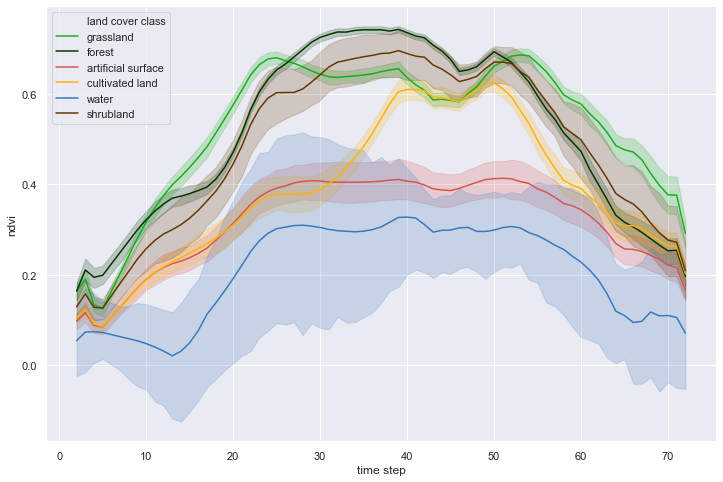

In [7]:
# plot time series
sns.set(rc={'figure.figsize':(12, 8)})
colors = ['green', 'dark green', 'pale red', 'amber', 'windows blue', 'brown']
g = sns.lineplot(x='time step', y='ndvi', hue='land cover class',
                 palette=sns.xkcd_palette(colors), 
                 data=df)

### Save dataset to disk

In [8]:
dataset_suffix = f'{k}x{n}px__interval_{interval}d'
dataset_suffix = dataset_suffix + '__sm' if smooth else dataset_suffix

data_dir = Path('data')
data_dir.mkdir(exist_ok=True)

with open(data_dir / f'features__{dataset_suffix}.pkl', mode='wb') as f:
    pickle.dump(features, f)
with open(data_dir / f'labels__{dataset_suffix}.pkl', mode='wb') as f:
    pickle.dump(labels, f)
with open(data_dir / f'timestamps__{dataset_suffix}.pkl', mode='wb') as f:
    pickle.dump(timestamps, f)
print(f'features__{dataset_suffix}.pkl')

features__4x12000px__interval_5d__sm.pkl
